In [ ]:
# Step 1: Install Kaggle and Authenticate
!pip install -q kaggle


In [ ]:
# Make sure to upload kaggle.json in Colab, then run these lines
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:

# Download the dataset
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset
!unzip tuberculosis-tb-chest-xray-dataset.zip -d chest_xray


Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
 99% 659M/663M [00:05<00:00, 125MB/s]
100% 663M/663M [00:05<00:00, 122MB/s]
Archive:  tuberculosis-tb-chest-xray-dataset.zip
  inflating: chest_xray/TB_Chest_Radiography_Database/Normal.metadata.xlsx  
  inflating: chest_xray/TB_Chest_Radiography_Database/Normal/Normal-1.png  
  inflating: chest_xray/TB_Chest_Radiography_Database/Normal/Normal-10.png  
  inflating: chest_xray/TB_Chest_Radiography_Database/Normal/Normal-100.png  
  inflating: chest_xray/TB_Chest_Radiography_Database/Normal/Normal-1000.png  
  inflating: chest_xray/TB_Chest_Radiography_Database/Normal/Normal-1001.png  
  inflating: chest_xray/TB_Chest_Radiography_Database/Normal/Normal-1002.png  
  inflating: chest_xray/TB_Chest_Radiography_Database/Normal/Normal-1003.png  
  inflating: chest_xray/TB_Chest_Radiography_Database/Normal/Normal-1004.png  
  inflating: chest_xray/TB_Chest_Radiography_Da

In [ ]:


# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


In [ ]:
# Set the image size and paths
IMG_SIZE = 128
BATCH_SIZE = 32
DATASET_PATH = '/content/chest_xray/TB_Chest_Radiography_Database'

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define paths for each class
normal_path = os.path.join('/content/chest_xray/TB_Chest_Radiography_Database/', 'Normal')
tuberculosis_path = os.path.join('/content/chest_xray/TB_Chest_Radiography_Database/', 'Tuberculosis')

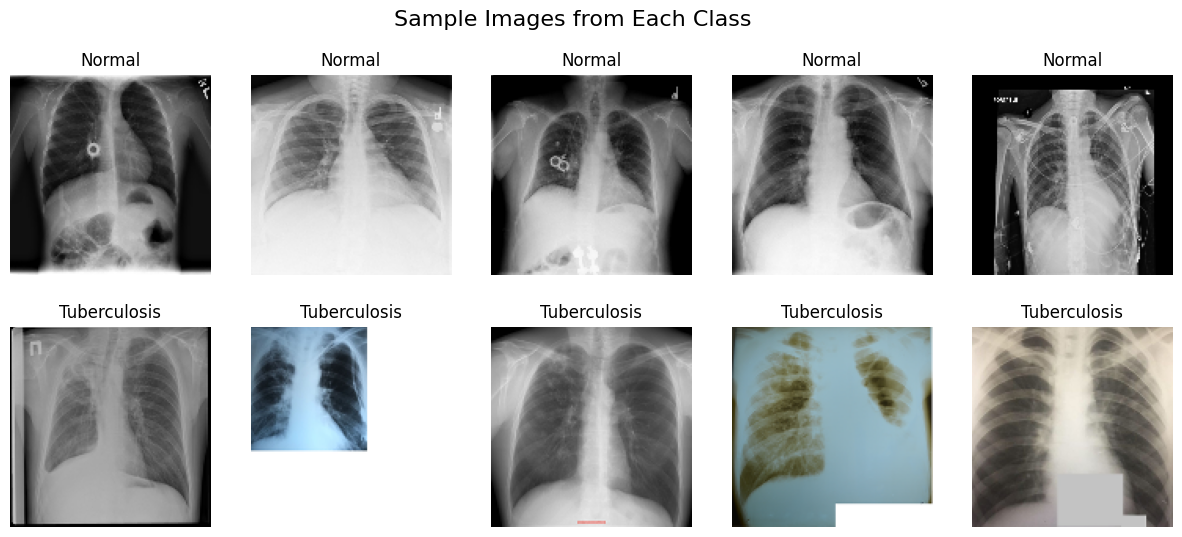

In [ ]:

# Function to plot sample images from each class
def plot_sample_images():
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle('Sample Images from Each Class', fontsize=16)

    # Load sample images from each class
    normal_images = random.sample(os.listdir(normal_path), 5)
    tuberculosis_images = random.sample(os.listdir(tuberculosis_path), 5)

    # Plot normal images
    for i, img_name in enumerate(normal_images):
        img = load_img(os.path.join(normal_path, img_name), target_size=(128, 128))
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        axes[0, i].set_title("Normal")


    # Plot tuberculosis images
    for i, img_name in enumerate(tuberculosis_images):
        img = load_img(os.path.join(tuberculosis_path, img_name), target_size=(128, 128))
        axes[1, i].imshow(img)
        axes[1, i].axis('off')
        axes[1, i].set_title("Tuberculosis")

    plt.show()

# Call the function
plot_sample_images()

Number of Normal images: 3500
Number of Tuberculosis images: 700


<ipython-input-9-e9d2e28232c4>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Normal', 'Tuberculosis'], y=[normal_count, tuberculosis_count], palette='viridis')


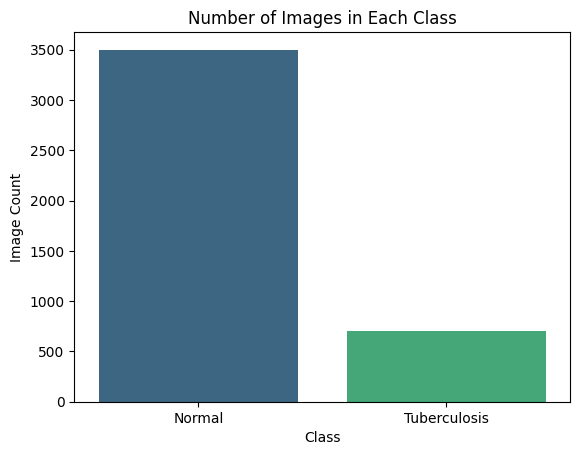

In [ ]:


# Function to plot image count for each class
def plot_image_counts():
    normal_count = len(os.listdir(normal_path))
    tuberculosis_count = len(os.listdir(tuberculosis_path))

    # Print the count of images in each class
    print(f"Number of Normal images: {normal_count}")
    print(f"Number of Tuberculosis images: {tuberculosis_count}")

    # Plot count of images in each class
    sns.barplot(x=['Normal', 'Tuberculosis'], y=[normal_count, tuberculosis_count], palette='viridis')
    plt.title('Number of Images in Each Class')
    plt.xlabel('Class')
    plt.ylabel('Image Count')
    plt.show()
# Call the functions

plot_image_counts()


In [ ]:
import shutil
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from PIL import Image

# Define paths
balanced_dataset_path = '/content/chest_xray/balanced_TB_Chest_Radiography_Database'
balanced_normal_path = os.path.join(balanced_dataset_path, 'Normal')
balanced_tuberculosis_path = os.path.join(balanced_dataset_path, 'Tuberculosis')

# Create directories for balanced dataset
os.makedirs(balanced_normal_path, exist_ok=True)
os.makedirs(balanced_tuberculosis_path, exist_ok=True)

# Copy Normal images to balanced dataset
for img_name in os.listdir(normal_path):
    shutil.copy(os.path.join(normal_path, img_name), balanced_normal_path)

# Initialize an ImageDataGenerator with augmentation transformations
augmenter = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Load and augment Tuberculosis images
tuberculosis_images = os.listdir(tuberculosis_path)
current_tuberculosis_count = len(tuberculosis_images)

# Loop until the Tuberculosis class matches the count of the Normal class
while len(os.listdir(balanced_tuberculosis_path)) < len(os.listdir(balanced_normal_path)):
    img_name = random.choice(tuberculosis_images)
    img_path = os.path.join(tuberculosis_path, img_name)

    # Load image
    img = load_img(img_path)
    img_array = img_to_array(img)  # Convert to array

    # Reshape the image array for augmentation (add batch dimension)
    img_array = np.expand_dims(img_array, axis=0)

    # Generate augmented images
    aug_iter = augmenter.flow(img_array, batch_size=1)
    aug_image = next(aug_iter)[0].astype(np.uint8)  # Take the first (and only) batch, convert to uint8

    # Convert back to an image and save with a unique name
    aug_img = array_to_img(aug_image)
    new_img_name = f"{os.path.splitext(img_name)[0]}_aug_{random.randint(0, 10000)}.jpeg"
    aug_img.save(os.path.join(balanced_tuberculosis_path, new_img_name))

# Print final counts for each class in the balanced dataset
print("Balanced Dataset:")
print(f"Number of Normal images: {len(os.listdir(balanced_normal_path))}")
print(f"Number of Tuberculosis images: {len(os.listdir(balanced_tuberculosis_path))}")


Balanced Dataset:
Number of Normal images: 3500
Number of Tuberculosis images: 3500


<ipython-input-11-c59f1b294d1b>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y='Count', data=df_counts, palette='viridis')


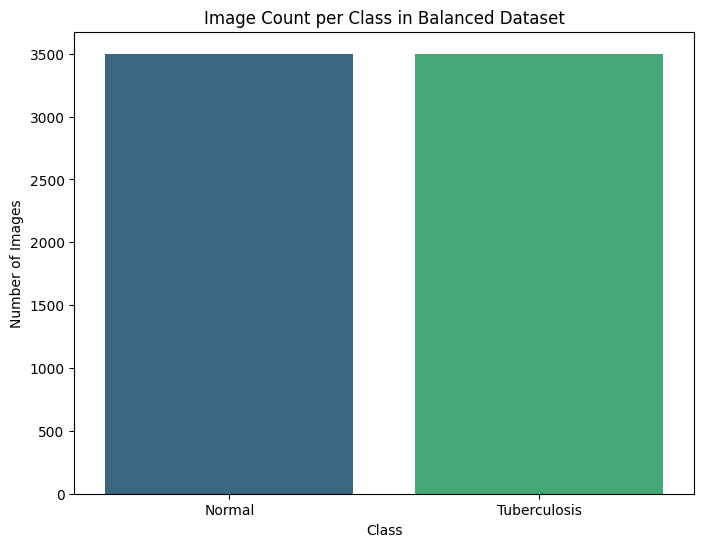

In [ ]:

# Count the images in each balanced class
normal_count = len(os.listdir(balanced_normal_path))
tuberculosis_count = len(os.listdir(balanced_tuberculosis_path))

# Create a dictionary with the counts
data = {'Class': ['Normal', 'Tuberculosis'], 'Count': [normal_count, tuberculosis_count]}

# Convert to a DataFrame for easier plotting
import pandas as pd
df_counts = pd.DataFrame(data)

# Plotting the count plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Class', y='Count', data=df_counts, palette='viridis')
plt.title("Image Count per Class in Balanced Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()